<a href="https://colab.research.google.com/github/fadlinisasiGit/SkinCan-model/blob/main/SkinCan_models_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product-Based-Capstone-Project**

**SkinCan Skin Cancer Detection App**

Final Selected Themes : Human Healthcare & Animal Welfare

Team Member :
*   (ML) M7134F1606 - Muhammad Fadli Ramadhan - Politeknik Negeri Sriwijaya
*   (ML) M2008F0851 - Adhitya Ghiffari Pramudito - Universitas Gadjah Mada
*   (MD) A2191F1821 - Ahmad Ansori Palembani - Universitas Bina Darma
*   (MD) A7191F1820 - Muhammad Fharid Akbar - Universitas Bina Darma
*   (CC) C2322F2819 - Muhammad Mustafa Kamal - Universitas Syiah Kuala
*   (CC) C7457F3068 - Wulan Ayu Rania Sari -Universitas Nahdlatul Ulama Lampung













**Executive Summary :**

At this time there are so many dangers that can lurk human health, even in this era of pandemic, maintaining health is very important for everyone. People should have awareness to maintain health, especially the health of the skin. Therefore, by utilizing machine learning, cloud computing to create a skin cancer detection application by identifying the input image to remind the public the importance of maintaining healthy skin. In this project, We have a problem formulation as follows:

*   How to detect various skin cancers in humans through the application?
*   How to treat skin cancer early?
*   How accurately does this application detect skin cancer?

Our team wants to solve this problem because we want someone who has the potential for cancer to avoid a more serious problem, so that users who use this application can take preventive measures to prevent this problem.

**How did your team come up with this project?**

We want to build an application that can help the public and health workers to detect skin diseases in humans, including skin cancer. This application uses Deep Learning algorithms to predict various skin diseases to achieve maximum accuracy in predicting skin diseases at an early stage. Feature extraction plays a key role in the classification of skin diseases. In addition, Explainable AI is used to interpret decisions made by our machine learning models. With this application, hopefully, it can help users to detect skin diseases early so they can take preventive measures.

**Based on your knowledge and explorations, tell us the Machine Learning Part of your capstone?**

In this project, we’re using Python as main programming language, Tensorflow as mandatory library, Sckit-learn and keras as libraries, AI Platform as platform, TFLite as Tools for Model Deployment to Android, Kaggle as dataset resource, Google Colab as IDE, and create Machine Learning Model as main the feature in our app.

## **Data Collecting**

**Download dataset from kaggle**

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install paket kaggle
!pip install -q kaggle

# Upload file kaggle.json dari Create New API Token Akun Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfadliramadhan","key":"25601c0254f1e180eb7b83717bc9463f"}'}

In [ ]:
# Download Dataset from Kaggle

import opendatasets as od
dataset_url= 'https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000'
od.download('https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000')

100%|██████████| 5.20G/5.20G [00:32<00:00, 169MB/s]


## **Pre-Model**

In [ ]:
import os
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from typing import Optional
from PIL import Image

In [ ]:
# Read the selected csv file
data = pd.read_csv('/content/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [ ]:
data.head()

**Understanding the data**

The dataset includes 10015 images that are 28 x 28 pixels = 784 pixels As they are RGB images and not gray scale they must be multipled by 3 (R, G, B). In total, there are 2352 pixels.

Normalization is achieved by diving by 255
Data is split into training, validation, and test sets using scikit-learn
A model to test is created

In [ ]:
X = data.drop(columns='label')/255
Y = data['label']

num_rows, num_cols = 28, 28
num_classes = len(set(Y))

In [ ]:
X = np.array(X)
X = X.reshape(X.shape[0], num_rows, num_cols, 3)

In [ ]:
Y = np.eye(num_classes)[np.array(Y.astype(int)).reshape(-1)]

**Train test spilts**

In this step we have splitted the dataset into training and testing set of 80:20 ratio

In [ ]:
#Split the dataset into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)


In [ ]:
#Split dataset into 10% of validation from training set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(num_rows, num_cols, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

**Changes to the model** Early stopping Changing the drop % Including a train, test split (+ validation split within training)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

**Training and validation split**

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [ ]:
#10% drop 30% drop 50% drop
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_validate, y_validate), callbacks=[learning_rate_reduction])


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Achieve a 93.5% Accuracy CNN The following model using image resizing, learning rate reduction, and image data augmentation in order to create a CNN model with 93.5% accuracy.

## **New-Model**

**Import Libraries**

In [ ]:
# importing Essential Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## **Data Undestanding**

**Making dictionary of images and labels**

In this step I have made the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part1.zip and HAM10000_images_part2.zip

In [ ]:
# Making Dictionary of images and labels
base_skin_dir = os.path.join('/content/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

**Reading and processing data**

In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir. After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [ ]:
# Reading & Processing data
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


**Data cleaning**

In this step we check for Missing values and datatype of each field

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
# Remove the null value in label age
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [ ]:
# Check the presensce of null values again
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [ ]:
# Check data type 
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


**Exploratoy Data Analysis**

In this we will explore different features of the dataset , their distrubtions and actual counts

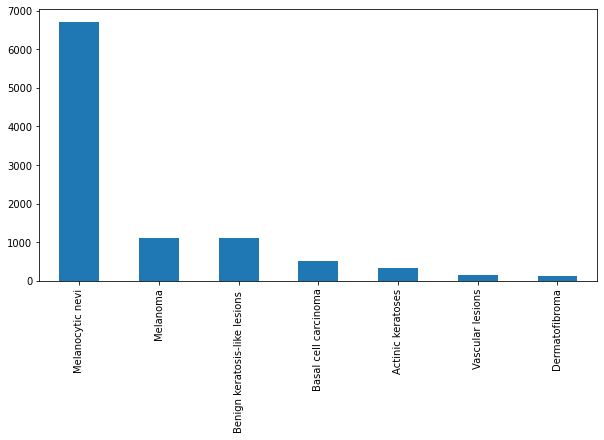

In [ ]:
# Plot to see distribution of 7 different classes of cell type
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

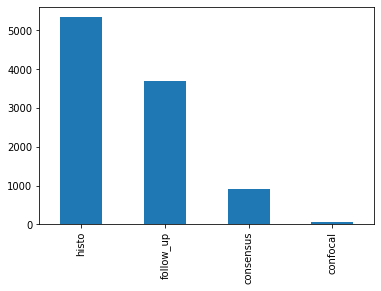

In [ ]:
# Plotting of Technical Validation field (ground truth)
skin_df['dx_type'].value_counts().plot(kind='bar')

Plotting of Technical Validation field (ground truth) which is dx_type to see the distribution of its 4 categories which are listed below :
1. Histopathology(Histo): Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

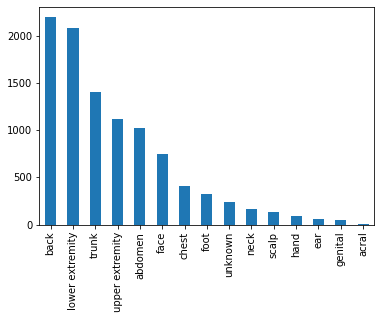

In [ ]:
# Plotting the distribution of localization field
skin_df['localization'].value_counts().plot(kind='bar')

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

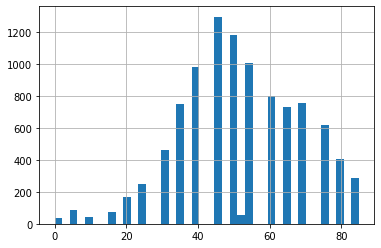

In [ ]:
# Now, check the distribution of Age
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

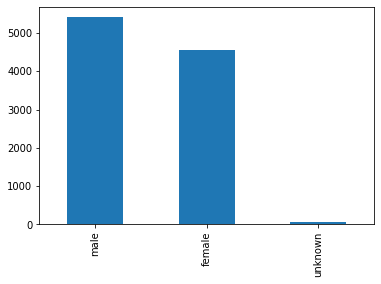

In [ ]:
# Lets see the distribution of males and females
skin_df['sex'].value_counts().plot(kind='bar')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


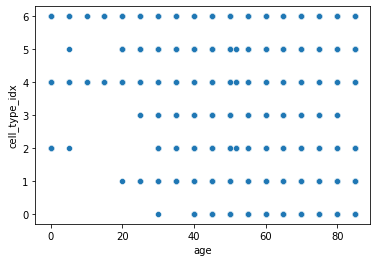

In [ ]:
# Now lets visualize agewise distribution of skin cancer types
sns.scatterplot('age','cell_type_idx',data=skin_df)

It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


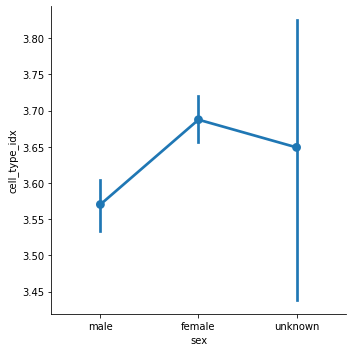

In [ ]:
# let's see the Sexwise distribution of skin cancer type
sns.factorplot('sex','cell_type_idx',data=skin_df)

## **Data Preparation**


**Load and resize of image**

In this step images will be loaded into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75. As this step resize all the 10015 images dimensions into 100x 75 so be patient it will take some time.

In [ ]:
# Resize images
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((28, 28))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


As we can see image column has been added in its color format code

Load images

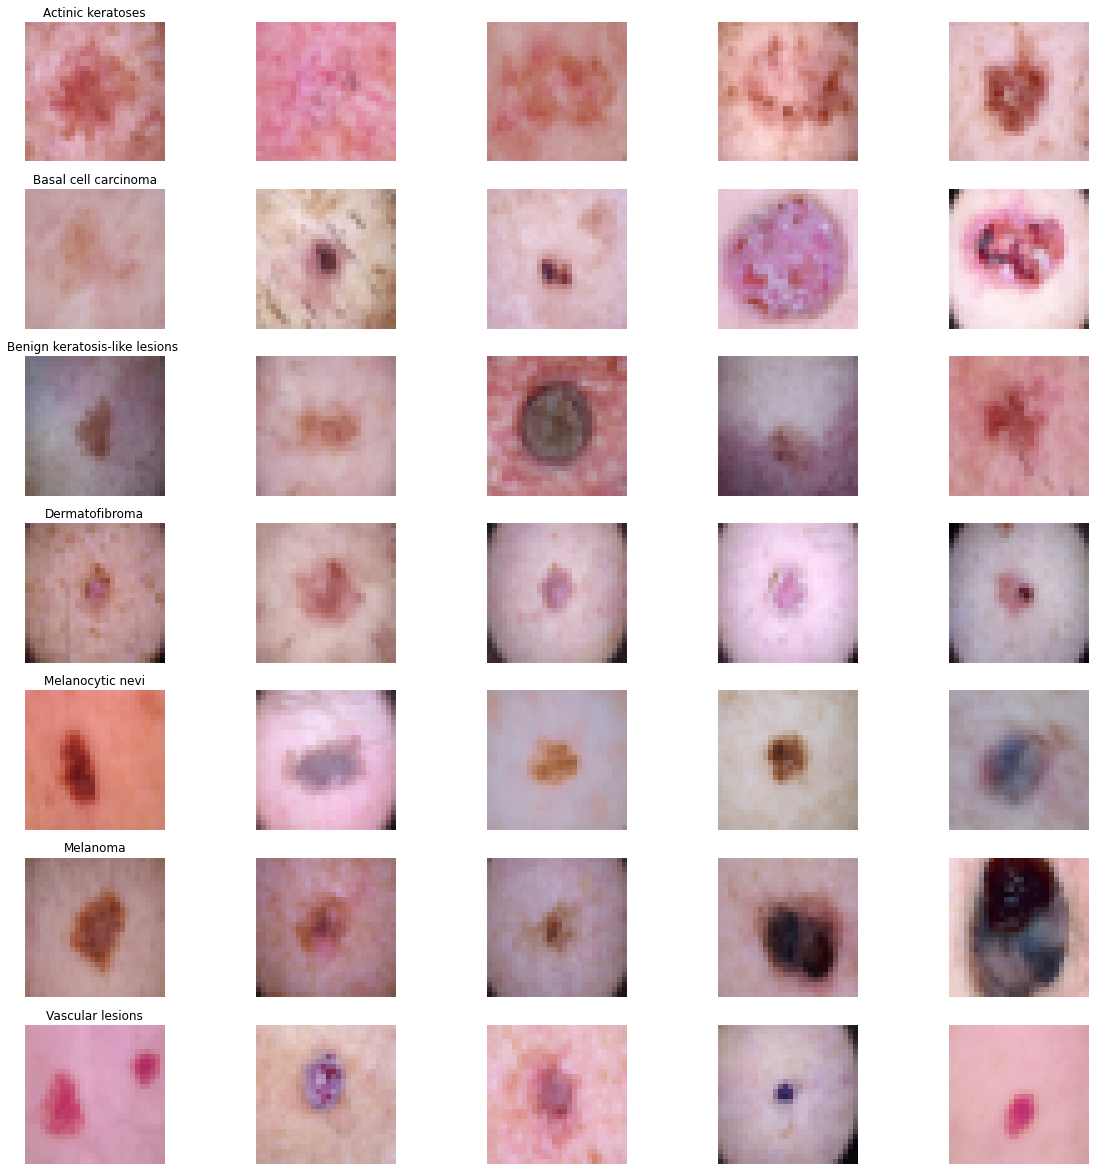

In [ ]:
# Most interesting part its always better to see sample of images Below we will show images of each cancer type
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(28, 28, 3)    10015
Name: image, dtype: int64

## **Modeling**

**Modeling CNN model**

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Architecture of CNN Model
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

input_shape = (28, 28, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.55),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

**Set OPtimizer and annealer**

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm. We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy". The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

**Learning Rate Reduction** The learning rate refers to how quickly the model can be adapted to the problem. It is a method update the weights during training. Depending on the size, the epochs need to be adjusted accordingly because smaller learning rates make smaller changes, thus need more epochs, while large learning rates result in rapid changes, thus need fewer epochs.

**Data Augmentation**

**Image Data Augmentation** A problem with this dataset includes the overfitting of one class. Therefore, in order to combat this I wanted to used ImageDataGenerator, a function in keras, which takes a batch of training images and applies transformations (i.e., rotation, zoom, shifts). After these transformations are completed, this function returns the original data and the transformed data. randomly transforming it, and then returning the transformed data, which is used to train the CNN.
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation, i choosed to : Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset .

**Fitting the model**

In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train

In [ ]:
# Fit the model (Iteration 1)
epochs = 50 
batch_size = 100
history = model.fit_generator(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_validate,y_validate),
    validation_steps=X_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Epoch 1/50
 1/72 [..............................] - ETA: 3s - loss: 0.0782 - accuracy: 0.8900

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


72/72 [==============================] - 4s 49ms/step - loss: 0.1240 - accuracy: 0.8134 - val_loss: 0.1544 - val_accuracy: 0.7606 - lr: 1.0000e-05
Epoch 2/50
72/72 [==============================] - 7s 99ms/step - loss: 0.1248 - accuracy: 0.8125 - val_loss: 0.1555 - val_accuracy: 0.7606 - lr: 1.0000e-05
Epoch 3/50
72/72 [==============================] - 6s 87ms/step - loss: 0.1235 - accuracy: 0.8150 - val_loss: 0.1543 - val_accuracy: 0.7618 - lr: 1.0000e-05
Epoch 4/50
72/72 [==============================] - 3s 42ms/step - loss: 0.1236 - accuracy: 0.8165 - val_loss: 0.1555 - val_accuracy: 0.7606 - lr: 1.0000e-05
Epoch 5/50
72/72 [==============================] - 3s 43ms/step - loss: 0.1243 - accuracy: 0.8143 - val_loss: 0.1554 - val_accuracy: 0.7606 - lr: 1.0000e-05
Epoch 6/50
72/72 [==============================] - 6s 87ms/step - loss: 0.1248 - accuracy: 0.8111 - val_loss: 0.1570 - val_accuracy: 0.7643 - lr: 1.0000e-05
Epoch 7/50
72/72 [==============================] - 7s 97ms/ste

## **Evaluation**



**Model Evaluation**

In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

KeyError: ignored

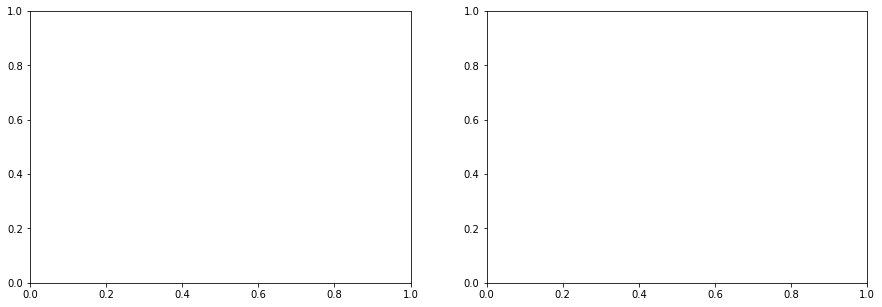

In [ ]:
plot_model_history(history)

In [ ]:
plt.figure(figsize=(15,6))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Now, lets which category has much incorrect predictions

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
sns.set_style('whitegrid')
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## **Conclusion**

It seems our model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code 0 where as Actinic keratoses code 4 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 80% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy

## **Saved Model Deployment**

In [ ]:
# SAVE MODEL TO JSON
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

print("Model saved")

In [ ]:
# Save Model to HDF5
model.save("model.h5")
print("Model saved")

In [ ]:
# save weights to HDF5
model.save_weights("model_weight.h5")
print("Model saved")

In [ ]:
# Save Model to Format TF-Lite
# Conversion Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save Model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# view the results of the model you have created on the Notebook.
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('You have an actinic keratosis skin cancer!')
  elif classes==1:
    print('You have a basal cell carcinoma skin cancer!')
  elif classes==2:
    print('You have a dermatofibroma skin cancer!')
  elif classes==3:
    print('You have a melanoma skin cancer!')
  elif classes==4:
    print('You have a nevus skin cancer!')
  elif classes==5:
    print('You have a pigmented benign keratosis skin cancer!')
  elif classes==6:
    print('You have a seborrheic keratosis skin cancer!')

  else:
    print('You don"t have skin cancer.')